### 1 Loading Dataset

In [5]:
import shutil
shutil.copytree('/content/drive/MyDrive/Project/data/', '/content/project_data/')

'/content/project_data/'

In [1]:
from google.colab import drive
import sys
import os

drive.mount('/content/drive')
sys.path.insert(0,'/content/drive/My Drive/Project/')

Mounted at /content/drive


In [25]:
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import random
import time
import torchvision.transforms as transforms

from my_datasets import MyDataset_CNN, MyDataset_CNN2
from my_models import MyModel_CNN, MyModel_CNNalex, MyModel_CNN2


In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(device)

True
cuda:0


In [9]:
#preprocess the txt file
ROOT = '/content/project_data/'
train_out = open(ROOT+"traindata_shuffle_img.txt",'w')
val_out = open(ROOT+"valdata_shuffle_img.txt",'w')
over_out = open(ROOT+"overdata_shuffle_img.txt",'w')
lines=[]
with open(ROOT+"data_all_transformation.txt", 'r') as infile:
    for line in infile:
        lines.append(line)
    random.shuffle(lines)
    num_train = np.ceil(0.8*len(lines))
    for count, line in enumerate(lines):
        if count <=num_train:
            if count< 4:
                over_out.write(line)
            train_out.write(line)
        else:
            val_out.write(line) 
train_out.close()            
val_out.close()
over_out.close()        

In [35]:
SIZE = (128,128)
TRANSFORM = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) 


over_data = MyDataset_CNN2(root = ROOT, txtname = 'overdata_shuffle_img.txt', transform=TRANSFORM, size=SIZE)
train_data = MyDataset_CNN2(root = ROOT, txtname = 'traindata_shuffle_img.txt' , transform = TRANSFORM, size= SIZE)
val_data = MyDataset_CNN2(root = ROOT, txtname = 'valdata_shuffle_img.txt', transform = TRANSFORM, size= SIZE)

over_loader = DataLoader(dataset=over_data, batch_size=4, shuffle=True)
train_loader = DataLoader(dataset=train_data, batch_size=256, shuffle=True, pin_memory=True, num_workers = 4)
val_loader = DataLoader(dataset=val_data, batch_size=256, shuffle=True, pin_memory=True, num_workers = 4)
# pin_memory=True, num_workers=4

print("Overfit size: %i" % len(over_data))
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))


Overfit size: 4
Train size: 50472
Validation size: 12616


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 128, 128])
tensor([[ 0.0476,  0.0476,  0.0651,  ...,  0.5378,  0.5378,  0.5203],
        [ 0.0476,  0.0651,  0.0651,  ...,  0.5378,  0.5378,  0.5378],
        [ 0.0651,  0.0826,  0.0826,  ...,  0.5553,  0.5553,  0.5378],
        ...,
        [ 0.4328,  0.3978,  0.3277,  ..., -0.2850, -0.3025, -0.3025],
        [ 0.4328,  0.3978,  0.3627,  ..., -0.3025, -0.3025, -0.2850],
        [ 0.3978,  0.3978,  0.3803,  ..., -0.3200, -0.3200, -0.3375]],
       dtype=torch.float64)


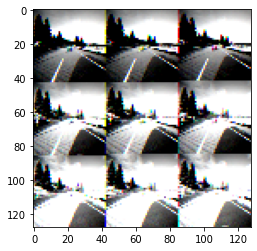

In [12]:
print(over_data[0][0][0].shape)
print(over_data[0][0][1])
#print(over_data[0][0][2])
plt.imshow(over_data[0][0][0].view(128,128,3))

### 2 Defining Neural Network

In [38]:
channel = [128, 128, 128, 64]
kernel = 2
neuron = [64, 32]
stride = 2 

#mynet = MyModel_CNNalex()
#print(mynet)


mynet= MyModel_CNN2(channel, kernel, neuron, stride) 
mynet.cuda()
print(mynet)

MyModel_CNN2(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (predict): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
  (pool): M

In [39]:
total_params = sum(p.numel() for p in mynet.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in mynet.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} trainable parameters.')

2,502,979 total parameters.
2,502,979 trainable parameters.


### 3 Training Neural network

In [15]:
#mycriterion = nn.SmoothL1Loss(reduction='mean') 
mycriterion = nn.MSELoss(reduction='mean') 
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-4, eps = 1e-08) 

In [17]:
def run_epoch(model,criterion,optimizer,dataloader,iftrain):    
    running_loss = 0.0 
    running_loss0 = 0.0
    running_loss1 = 0.0
    running_loss2 = 0.0 
    
    #Iterating through the minibatches of the data
    for i, data in enumerate(dataloader, 0): 
        X, y = data
        X = [x.cuda() for x in X]
        #X = X.float().cuda()
        y = y.cuda() 
        
        if iftrain:  
            optimizer.zero_grad()
            y_pred = model(X) 
            y_pred = y_pred.float() 
            y = y.float()
            loss = criterion(y_pred, y) 
            loss0 = criterion(y_pred[:,0], y[:,0])
            loss1 = criterion(y_pred[:,1], y[:,1])
            loss2 = criterion(y_pred[:,2], y[:,2]) 
            #loss = (loss0 + loss1 + loss2)/3   
            loss.backward()             
            optimizer.step()
            running_loss += loss.item()
            running_loss0 += loss0.item() 
            running_loss1 += loss1.item()
            running_loss2 += loss2.item()             
            
        else:
            y_pred = model(X)
            y_pred = y_pred.float()  
            y = y.float()
            loss = criterion(y_pred, y)
            loss0 = criterion(y_pred[:,0], y[:,0])
            loss1 = criterion(y_pred[:,1], y[:,1])
            loss2 = criterion(y_pred[:,2], y[:,2])  
            #loss = (loss0 + loss1 + loss2)/3

            running_loss += loss.item()
            running_loss0 += loss0.item() 
            running_loss1 += loss1.item()
            running_loss2 += loss2.item()      
    return running_loss, running_loss0, running_loss1, running_loss2   

In [40]:
# test if the model will overfit with only one sample
max_epochs = 1000
train_history = []
val_history = []
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-4, eps = 1e-08) 
#scheduler = optim.lr_scheduler.CosineAnnealingLR(myoptimizer, max_epochs)
for epoch in range(max_epochs):
    '''
    if epoch >= 1999 and epoch <= 2999:
        myoptimizer.param_groups[0]['lr'] = 1e-5
    elif epoch > 2999:
        myoptimizer.param_groups[0]['lr'] = 1e-6
        
    scheduler.step()
    '''
    start = time.time()
    train_loss,_,_,_ = run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=over_loader,
                           iftrain=True)
    train_history.append(train_loss)
    val_loss, val_loss0, val_loss1, val_loss2 =  run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=over_loader,
                           iftrain=False)
    val_history.append(val_loss)
    end = time.time()
    if epoch % 50 == 49:
        print('Epoch %.0f / 1000, train_loss: %2e, val_loss: %2e(%2e,%2e,%2e), runtime:% s' % 
              (epoch+1, train_loss, val_loss, val_loss0, val_loss1, val_loss2, end-start))
        #print(f"Epoch {epoch + 1: >3}/{max_epochs}, train_loss: %2e, val_loss: %2e " %  (train_loss/4, val_loss/4))
        #print(scheduler.get_last_lr())

Epoch 50 / 1000, train_loss: 3.182415e-02, val_loss: 2.476464e-02(6.981724e-02,2.026604e-03,2.450082e-03), runtime:0.024903535842895508
Epoch 100 / 1000, train_loss: 8.629730e-05, val_loss: 1.464628e-04(4.157620e-04,1.539333e-05,8.232973e-06), runtime:0.02541494369506836
Epoch 150 / 1000, train_loss: 3.080668e-07, val_loss: 3.678167e-07(6.003391e-07,1.704589e-07,3.326522e-07), runtime:0.025072336196899414
Epoch 200 / 1000, train_loss: 5.208569e-08, val_loss: 3.200487e-07(7.437223e-07,3.494895e-08,1.814748e-07), runtime:0.025003910064697266
Epoch 250 / 1000, train_loss: 3.343546e-08, val_loss: 5.886917e-08(1.678518e-08,7.197191e-08,8.785043e-08), runtime:0.0250244140625
Epoch 300 / 1000, train_loss: 1.485707e-07, val_loss: 6.256302e-07(9.249821e-07,6.252513e-08,8.893834e-07), runtime:0.025329113006591797
Epoch 350 / 1000, train_loss: 9.649369e-08, val_loss: 8.055012e-08(1.205865e-07,4.926024e-08,7.180357e-08), runtime:0.024973392486572266
Epoch 400 / 1000, train_loss: 3.486673e-07, val_

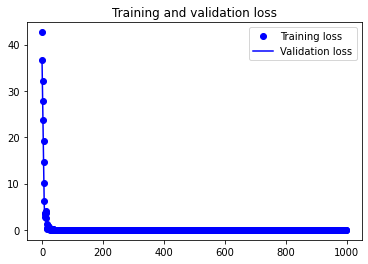

In [27]:
# plot the train&validation loss curve with only one sample
epochs = range(len(train_history))
plt.figure()
plt.plot(epochs, train_history, 'bo', label='Training loss')
plt.plot(epochs, val_history, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [41]:
#TEST = random.randint (0, 3)
for i in range(3):
  test_in, gt_output = over_data[i]
  #print(test_in.shape)
  test_in = [torch.tensor(x).to(device) for x in test_in] 
  #test_in = torch.tensor(test_in).to(device)
  gt_output = torch.tensor(gt_output).to(device)
  mynet.eval() 
  output_pred = mynet(test_in) 
  #print('TEST', TEST)
  #print('test_in',test_in)
  print('prediction:{}, ground truth:{}'.format(output_pred.cpu().detach().numpy(), gt_output.cpu().detach().numpy()))

prediction:[[-1.5425752e+01  2.9320180e-02 -2.9463395e-03]], ground truth:[-1.54254855e+01  2.89421529e-02 -1.89630385e-03]
prediction:[[-12.692151    -0.5341029    0.17041795]], ground truth:[-12.69321758  -0.5334528    0.17045136]
prediction:[[-6.7580934  -0.24670225  0.20827769]], ground truth:[-6.75772862 -0.24696982  0.20843683]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [29]:
# start the main training process

num_trainbatch = np.ceil(len(train_data)/256) 
num_valbatch = np.ceil(len(val_data)/256) 
train_history = []
val_history = []

min_loss = 100000
current_patience = 0
patience = 5



In [ ]:
! /opt/bin/nvidia-smi

Mon Jan 24 14:11:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    36W / 250W |   2611MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [51]:
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-5, eps = 1e-08) 
max_epochs = 30
print('Start training!')
for epoch in range(max_epochs): 
    '''
    if epoch >= 2999 and epoch <= 3999:
        myoptimizer.param_groups[0]['lr'] = 1e-5
    elif epoch > 3999:
        myoptimizer.param_groups[0]['lr'] = 1e-6
    '''
    start = time.time()
    train_loss,_,_,_ = run_epoch(model=mynet, criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=train_loader,
                           iftrain=True)
    train_history.append(train_loss)
    val_loss, val_loss0, val_loss1, val_loss2 =  run_epoch(model=mynet, criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=val_loader,
                           iftrain=False)
    val_history.append(val_loss)
    end = time.time()
    #if epoch % 50 == 49:
    print('Epoch %.0f / 100, train_loss: %2e, val_loss: %2e(%2e,%2e,%2e), runtime:% s' % 
              (epoch+1, train_loss/num_trainbatch, val_loss/num_valbatch, val_loss0/num_valbatch, val_loss1/num_valbatch, val_loss2/num_valbatch, end-start))
'''
    # early stopping
    if min_loss == 100000 or val_loss < min_loss :
        min_loss = val_loss
        current_patience = 0
        torch.save(mynet.state_dict(),'mynet.pth')
      
    else :
        current_patience += 1 
        if current_patience >= patience :
            print("Stopping early at epoch {}!".format(epoch+1)) 
            break   
'''
print('FINISH.')
# save trained model
#torch.save(mynet.state_dict(),'/content/drive/My Drive/Project/mynet_cnn_img.pth')
print('model saved')

Start training!
Epoch 1 / 100, train_loss: 4.391405e-03, val_loss: 7.041620e-02(1.570279e-01,5.108650e-02,3.134170e-03), runtime:87.62402987480164
Epoch 2 / 100, train_loss: 4.303307e-03, val_loss: 6.994203e-02(1.561580e-01,5.054842e-02,3.119729e-03), runtime:87.38433289527893
Epoch 3 / 100, train_loss: 4.208942e-03, val_loss: 7.060766e-02(1.576532e-01,5.106022e-02,3.109580e-03), runtime:87.18786358833313
Epoch 4 / 100, train_loss: 4.135728e-03, val_loss: 7.405879e-02(1.667522e-01,5.231558e-02,3.108614e-03), runtime:82.91243124008179
Epoch 5 / 100, train_loss: 4.076037e-03, val_loss: 6.959922e-02(1.550985e-01,5.060090e-02,3.098231e-03), runtime:84.86216711997986
Epoch 6 / 100, train_loss: 4.010347e-03, val_loss: 7.064174e-02(1.574418e-01,5.141110e-02,3.072263e-03), runtime:87.85010957717896
Epoch 7 / 100, train_loss: 3.967154e-03, val_loss: 7.171971e-02(1.612227e-01,5.085939e-02,3.077013e-03), runtime:88.10533809661865
Epoch 8 / 100, train_loss: 3.932717e-03, val_loss: 7.026968e-02(1.5

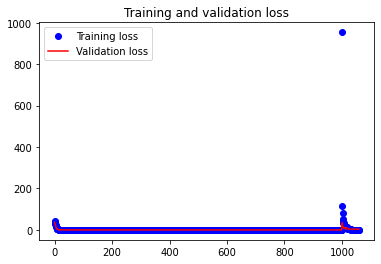

In [49]:
# plot the train&validation loss curve 
epochs = range(len(train_history))
plt.figure()
plt.plot(epochs, train_history, 'bo', label='Training loss')
plt.plot(epochs, val_history, 'r', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()


In [48]:
# save trained model
torch.save(mynet.state_dict(),'/content/drive/My Drive/Project/mynet_cnn_img2.pth')

In [ ]:
mynet.load_state_dict(torch.load('/content/drive/My Drive/Project/mynet_cnn_img.pth'))
#, map_location='cpu'

<All keys matched successfully>

In [50]:
for i in range(50):
  TEST = random.randint (0, 100)
  test_in, gt_output = val_data[TEST]
  test_in = [torch.tensor(x).to(device) for x in test_in]
  #test_in = torch.tensor(test_in).to(device)
  gt_output = torch.tensor(gt_output).to(device)
  output_pred = mynet(test_in) 
  #print('TEST', TEST)
  #print('test_in',test_in)
  print('prediction:{}, ground truth:{}'.format(output_pred.cpu().detach().numpy(), gt_output.cpu().detach().numpy()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


prediction:[[-8.048931    0.6977423  -0.17755412]], ground truth:[-8.04265802  0.66191636 -0.13693345]
prediction:[[-9.1386595   0.8394797   0.11244014]], ground truth:[-9.05906544  0.78962191  0.16809713]
prediction:[[-14.828245    -0.31219774   0.03153013]], ground truth:[-13.87515961  -0.29167204   0.06504025]
prediction:[[-7.4790573  -0.43672726  0.10347253]], ground truth:[-7.55206094 -0.44888598  0.10359883]
prediction:[[-15.682206    -2.0819829    0.28077647]], ground truth:[-16.51141458  -2.28293173   0.32144408]
prediction:[[-7.7531457   0.51997495 -0.07751219]], ground truth:[-7.75086783  0.44462133 -0.09460247]
prediction:[[-10.976767     0.77874595  -0.16337089]], ground truth:[-10.74618957   0.60534283  -0.11821959]
prediction:[[-5.1505733   1.4661249  -0.50742304]], ground truth:[-4.91253422  1.47770627 -0.52121134]
prediction:[[-7.3212085e+00 -1.8756203e-03  4.9674660e-03]], ground truth:[-7.26582761e+00 -2.76838052e-02 -1.26060730e-03]
prediction:[[-7.6568856   0.435321